In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from torchvision.models.vgg import VGG
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import nibabel as nib
import torch.nn.functional as F

%matplotlib inline

In [3]:
class _DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_DoubleConv, self).__init__()
        # [3x3 conv with the 'same' padding, batch norm, relu activation] * 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        outputs = self.conv(x)
        
        return outputs

class InConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InConv, self).__init__()
        self.conv = _DoubleConv(in_channels, out_channels)

    def forward(self, x):
        outputs = self.conv(x)

        return outputs


class DownSamp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSamp, self).__init__()
        self.down_samp = nn.Sequential(
            nn.MaxPool2d(2),
            _DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        outputs = self.down_samp(x)

        return outputs


class UpSamp(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super(UpSamp, self).__init__()
        if bilinear:
            self.up = nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, padding=0, stride=1),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                )
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2,\
                kernel_size=4, stride=2, padding=1)
        self.conv = _DoubleConv(in_channels, out_channels)
        
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # x1, x2 follow NCHW pattern
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        # (left, right, top, bottom), default zero-pad
        x1 = F.pad(x1, (diff_x // 2, diff_x - diff_x // 2,
        diff_y // 2, diff_y - diff_y // 2), mode='constant', value=0)

        # after necessary paddings, x1 and x2 should have the same dimension
        # concatenate them in the second dimension
        x = torch.cat((x1, x2), dim=1)
        outputs = self.conv(x)

        return outputs

class OutConv(nn.Module):
    def __init__(self, in_channels, class_num):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, class_num, kernel_size=1)

    def forward(self, x):
        outputs = self.conv(x)

        return outputs

In [4]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inp_conv = InConv(n_channels, 64)
        self.down1 = DownSamp(64, 128)
        self.down2 = DownSamp(128, 256)
        self.down3 = DownSamp(256, 512)
        self.down4 = DownSamp(512, 1024)
        self.up1 = UpSamp(1024, 512)
        self.up2 = UpSamp(512, 256)
        self.up3 = UpSamp(256, 128)
        self.up4 = UpSamp(128, 64)
        self.out_conv = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inp_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        outputs = self.up1(x5, x4)
        outputs = self.up2(outputs, x3)
        outputs = self.up3(outputs, x2)
        outputs = self.up4(outputs, x1)

        outputs = self.out_conv(outputs)

        return outputs


In [4]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False, batch_norm=False):
        super().__init__(make_layers(cfg[model], batch_norm=batch_norm))
        self.ranges = ranges
        self.model_urls = {
            'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
            'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
        }
        if batch_norm:
            self.model = 'vgg16_bn'
        else:
            self.model = 'vgg16'

        if pretrained:
            #exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
            self.load_state_dict(model_zoo.load_url(self.model_urls[self.model]))

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges[self.model])):
            for layer in range(self.ranges[self.model][idx][0], self.ranges[self.model][idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg16_bn': ((0, 7), (7, 14), (14, 24), (24, 34), (34, 44)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [5]:
# transforms
class ToTensor():
    """
    Convert ndarray samples to Tensors
    """
    def __call__(self, sample):
        sc, mask = sample
        
        sc = torch.from_numpy(sc).float()
        mask = torch.from_numpy(mask).float()
        
        return sc, mask
    

class NormalizeBRATS():
    """
    Subtract the mean and divide by the standard deviation
    """
    def __call__(self, sample):
        sc, mask = sample
        
        mean = torch.mean(sc, dim=(1, 2), keepdim=True)
        std = torch.std(sc)
        
        if std == 0:
            sc = sc.sub(mean)
        else:
            sc = sc.sub(mean).div(std)
        
        return sc, mask

In [16]:
def visualize_inference(model, base_path, img_name, seg_type='et'):
    """
    Plot the original image, predicted dense labels and the ground-true labels.
    Parameters:
    - model: PyTorch model
    - base_path: path to the augmented Pascal VOC dataset
    - img_name: image file name without format extension
                e.g. 2008_000073 is the img_path for 2008_000073.jpg and 2008_000073.mat
    - center_crop: whether crop to certain height, width for better visualization
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 20))
    voc_colors = [[0, 0, 0], [0, 192, 0]]

    voc_classes = ['background', f'{seg_type}']
    
    scan_path = os.path.join(base_path, img_name + '_scan.npy')
    mask_path = os.path.join(base_path, img_name + f'_{seg_type}.npy')
    ind2color = {}
    legend_elements = []
    for ind, color in enumerate(voc_colors):
        ind2color[ind] = (color, voc_classes[ind])
        legend_elements.append(Line2D([0], [0], color=np.array(color)/255, lw=6))
    
    sc = np.load(scan_path)[1]
    ax1.set_title('original image')
    ax1.imshow(sc)
    sc = np.expand_dims(sc, axis=0)
    assert sc.shape == (1, 240, 240)
    
    mask = np.load(mask_path)
    assert mask.shape == (240, 240)
    
    
    to_tensor = ToTensor()
    normalize_BraTS = NormalizeBRATS()
    sc, mask = to_tensor((sc, mask))
    sc, mask = normalize_BraTS((sc, mask))
    mask = mask.numpy()
    
    # unsqueeze to 4-dimension NxCxHxW
    sc = torch.unsqueeze(sc, dim=0)
    model.eval()
    with torch.no_grad():
        output = model(sc)
        pred = torch.argmax(output, dim=1)
    
    # squeeze the dense label back to a 3-dimension tensor, CHW
    pred = torch.squeeze(pred, dim=0)
    
    pred = pred.numpy()
    height, width = pred.shape
    
    colored_pred = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_pred[h, w] = ind2color[pred[h, w]][0]
    
    ax2.set_title('predicted feature map')
    ax2.imshow(colored_pred)
    
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_mask[h, w] = ind2color[mask[h, w]][0]
            
    ax3.set_title('ground true dense label')
    ax3.legend(handles=legend_elements, labels=voc_classes, loc='upper center', bbox_to_anchor=(1.5, 1.2))
    ax3.imshow(colored_mask)

# Enhancing tumor segmentation

In [8]:
unet_state_dict = '../scores/UNet_BraTS2018/trained_model.pt'
unet = UNet(n_channels=1, n_classes=2)
unet.load_state_dict(torch.load(unet_state_dict, map_location='cpu'))

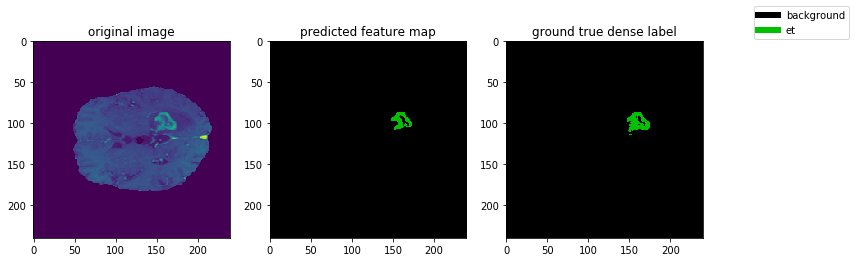

In [18]:
base_path = './BRATS2018/seg/val/'
visualize_inference(unet, base_path, img_name='Brats18_CBICA_AYU_1_070')